Using device: cuda
--- Training VAE with latent_dim = 16 ---
Epoch: 1/1
  Training Loss: 188.2545
  Validation Loss: 87.7962
--- Finished training VAE with latent_dim = 16 ---
--- Training AE with latent_dim = 16 ---
Epoch: 1/1
  Training Loss: 56.1414
  Validation Loss: 18.8414
--- Finished training AE with latent_dim = 16 ---


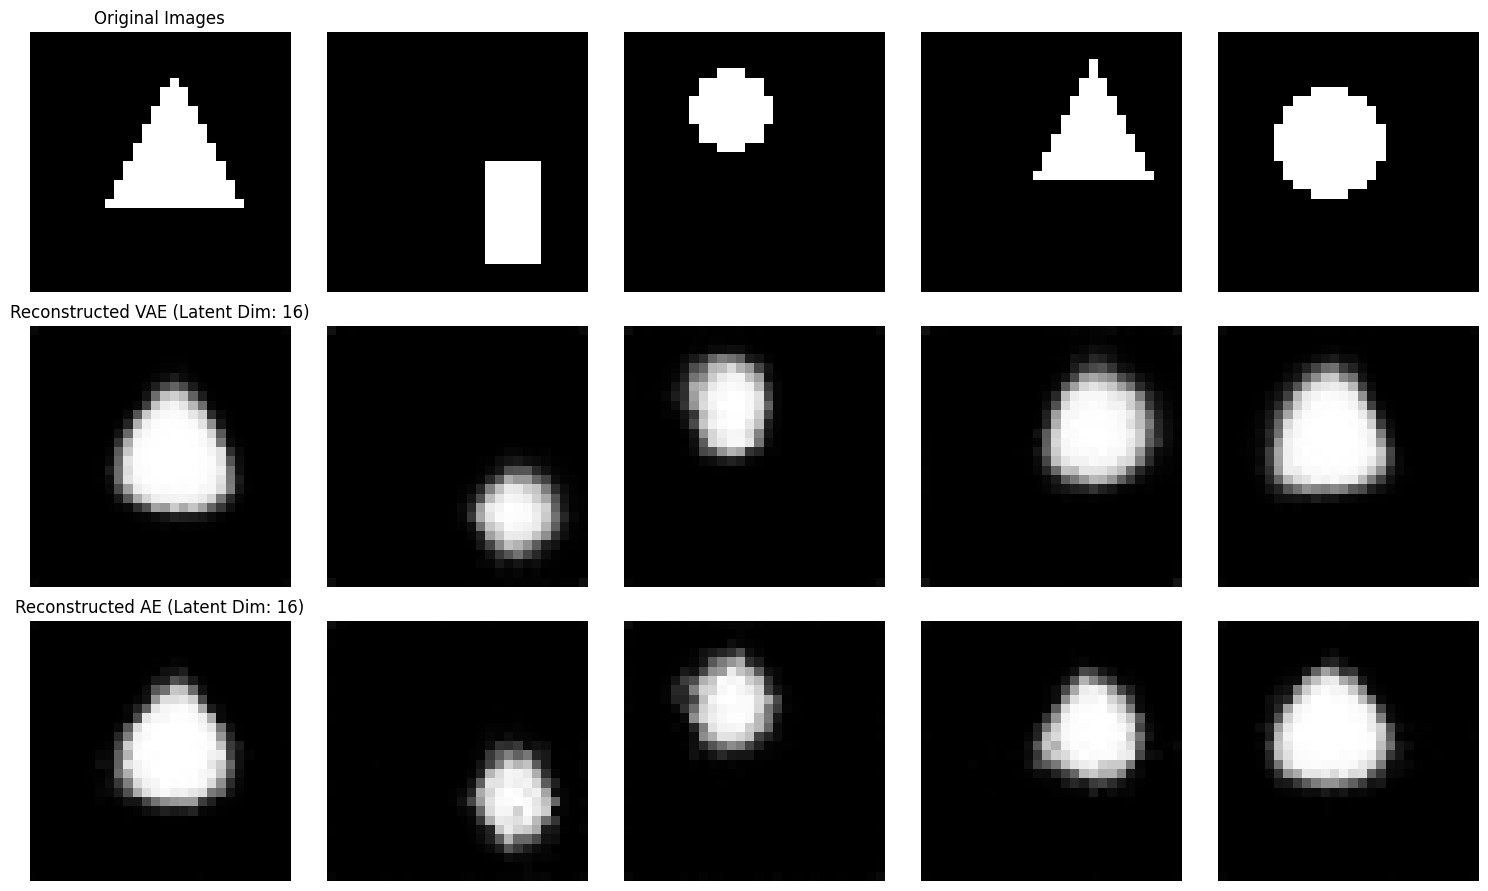

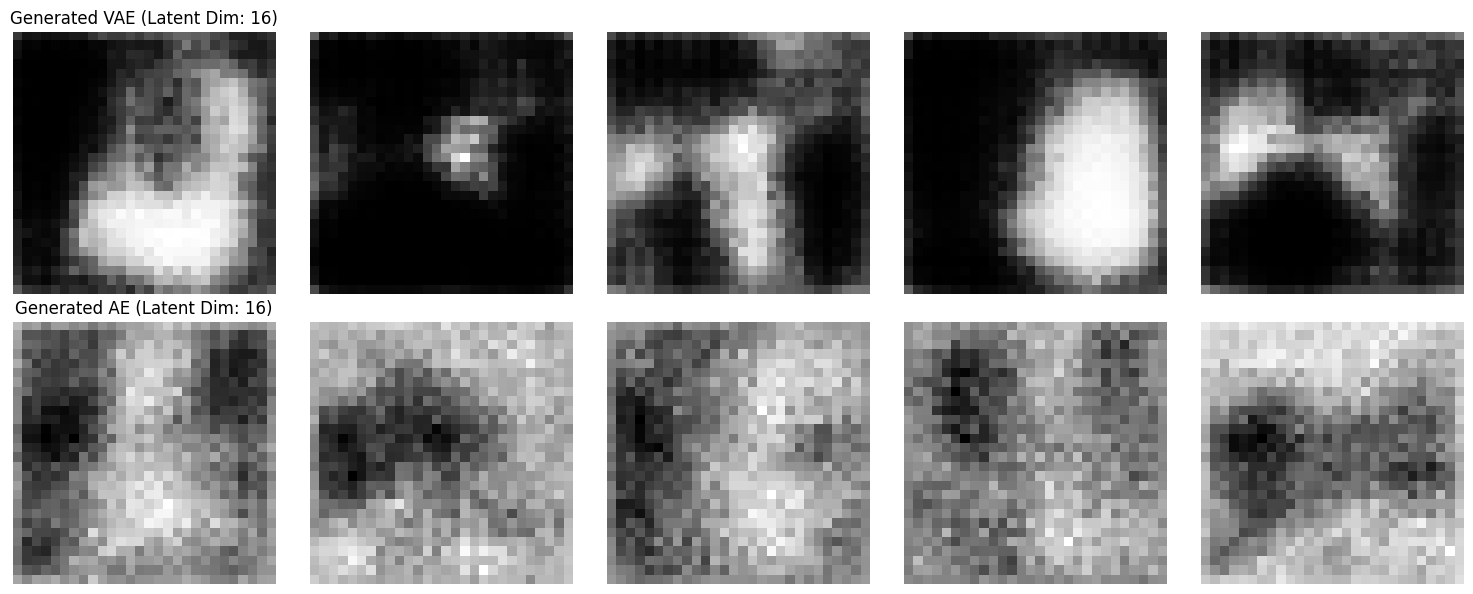

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import random

# Define the device at the start
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

latent_dim = 32

# Class to create dataset of images
class ShapeDataset(Dataset):
  # Initialise variables
    def __init__(self, num_images, img_size=(28, 28)):
        self.num_images = num_images
        self.img_size = img_size
        self.shapes = ['circle', 'triangle', 'rectangle']
        self.num_shapes = len(self.shapes)

    # Return length
    def __len__(self):
        return self.num_images

  # Create and return shape instance
    def __getitem__(self, idx):
        # Choose a random shape
        shape_type = random.choice(self.shapes)
        label = self.shapes.index(shape_type)

        # Create a grayscale PIL image (black background)
        img = Image.new('L', self.img_size, 'black')
        draw = ImageDraw.Draw(img)
    
        x_max, y_max = self.img_size

        # Draw circle
        if shape_type == 'circle':
            side_length = random.randint(5, int(min(x_max, y_max) * 0.6))
            x1 = random.randint(1, x_max - side_length - 2)
            y1 = random.randint(1, y_max - side_length - 2)
            x2 = x1 + side_length
            y2 = y1 + side_length
            
            draw.ellipse([x1, y1, x2, y2], fill='white')

        # Draw triangle
        elif shape_type == 'triangle':
            center_x = random.randint(10, x_max - 10)
            center_y = random.randint(10, y_max - 10)
            radius = random.randint(5, min(center_x, center_y, x_max - center_x, y_max - center_y) - 1)
            
            v1 = (center_x, center_y - radius)
            v2 = (center_x - int(radius * 0.866), center_y + int(radius * 0.5))
            v3 = (center_x + int(radius * 0.866), center_y + int(radius * 0.5))
            
            draw.polygon([v1, v2, v3], fill='white')

        # Draw square
        elif shape_type == 'rectangle':
            x1 = random.randint(1, int(x_max * 0.7))
            y1 = random.randint(1, int(y_max * 0.7))
            x2 = random.randint(x1 + 5, x_max - 2)
            y2 = random.randint(y1 + 5, y_max - 2)
            draw.rectangle([x1, y1, x2, y2], fill='white')

        # Get a tensor of the image
        img_array = np.array(list(img.getdata()))
        img_tensor = torch.from_numpy(img_array).reshape(1, self.img_size[0], self.img_size[1]).float() / 255.0
    
        return img_tensor, torch.tensor(label, dtype=torch.long)


class VAEModel(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(VAEModel, self).__init__()

        self.latent_dim = latent_dim
        input_dims = 28 * 28
        encoder_out_dims = 64*7*7

        # Encoder Network (from 784 to latent space)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )

        # The linear layers that map to the latent space's mean and log-variance
        self.fc_mu = nn.Linear(encoder_out_dims, latent_dim)
        self.fc_log_var = nn.Linear(encoder_out_dims, latent_dim)

        # Decoder Network (from latent space back to 784)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, encoder_out_dims),
            nn.Unflatten(1, (64,7,7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.fc_mu(x), self.fc_log_var(x)
        return mean, logvar

    def decode(self, x):
        return self.decoder(x)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_mu(h), self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# Simple AE model
class AEModel(nn.Module):
    def __init__(self, latent_dim=latent_dim, noise_std=0.3):
        super(AEModel, self).__init__()

        self.latent_dim = latent_dim
        self.noise_std = noise_std
        input_dims = 28 * 28
        encoder_out_dims = 64 * 7 * 7

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_latent = nn.Linear(encoder_out_dims, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, encoder_out_dims),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        h = self.encoder(x)
        z = self.fc_latent(h)
        x_recon = self.decoder(z)
        return x_recon, z

    def decode(self, x):
        return self.decoder(x)


def VAEloss(reconstructed_x, x, mu,  log_var):
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    kl_div_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_div_loss

def AEloss(reconstructed_x, x, z, noise_std, lambda_reg=0.01):
    # Noise
    noise = torch.randn_like(z) * noise_std
    z_noisy = z + noise

    # MSE Loss
    reconstruction_loss = F.mse_loss(model.decoder(z_noisy).view(-1, 28*28), x.view(-1, 28*28), reduction='sum')

    # Variance control
    mean_reg = torch.mean(z.pow(2))
    var_reg = torch.mean((z.std(dim=0) - 1).pow(2))
    
    total_loss = reconstruction_loss + lambda_reg * (mean_reg + var_reg)
    return total_loss


def train_ae(model, train_dataloader, val_dataloader, optimizer, epochs, noise_std):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for images, _ in train_dataloader:
            images = images.to(device)
            reconstructed_images, z = model(images)
            
            loss = AEloss(reconstructed_images, images, z, noise_std)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_dataloader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_dataloader:
                images = images.to(device)
                reconstructed_images, z = model(images)
            
                loss = AEloss(reconstructed_images, images, z, noise_std)
                val_loss += loss.item()
    
        avg_val_loss = val_loss / len(val_dataloader.dataset)

        print(f"Epoch: {epoch+1}/{epochs}")
        print(f"  Training Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")

def train(model, train_dataloader, val_dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for images, _ in train_dataloader:
            images = images.to(device)
            
            
            reconstructed_images, mu, log_var = model(images)
            loss = VAEloss(reconstructed_images, images, mu, log_var)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_dataloader.dataset)

        # 2. Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_dataloader:
                images = images.to(device)
                reconstructed_images, mu, log_var = model(images)
                
                loss = VAEloss(reconstructed_images, images, mu, log_var)
                val_loss += loss.item()
    
        avg_val_loss = val_loss / len(val_dataloader.dataset)

        print(f"Epoch: {epoch+1}/{epochs}")
        print(f"  Training Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")


# Set hyperparameters
learning_rate = 1e-3
epochs = 1
batch_size = 64
num_images = 10000
noise_std = 0.3

# Prepare the data
dataset = ShapeDataset(num_images=num_images)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

latent_dims = [16]
model_types = ["VAE", "AE"]
trained_models = {}

for model_type in model_types:
    for latent_dim in latent_dims:
        print(f"--- Training {model_type} with latent_dim = {latent_dim} ---")
        
        if(model_type == "VAE"):
            model = VAEModel(latent_dim=latent_dim)
        else:
            model = AEModel(latent_dim=latent_dim)
        model.to(device)
    
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
        if(model_type == "VAE"):
            train(model, train_dataloader, val_dataloader, optimizer, epochs)
        else:
            train_ae(model, train_dataloader, val_dataloader, optimizer, epochs, noise_std)
        
        trained_models[(model_type, latent_dim)] = model
    
        print(f"--- Finished training {model_type} with latent_dim = {latent_dim} ---")


"""
# Initialize the model and optimizer
model = AEModel()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
model.to(device)
if isinstance(model, VAEModel):
    train(model, train_dataloader, val_dataloader, optimizer, epochs)
else:
    train_ae(model, train_dataloader, val_dataloader, optimizer, epochs, noise_std)

# Print out outputs
model.eval()
with torch.no_grad():
    for images, _ in val_dataloader:
        images = images.to(device)
        if isinstance(model, VAEModel):
            reconstructed_images, _, _ = model(images)
        else:
            reconstructed_images, _ = model(images)
        break

reconstructed_images = reconstructed_images.cpu()
images = images.cpu()

# Display original and reconstructed images
n = 5
fig, axes = plt.subplots(2, n, figsize=(15, 8))
for i in range(n):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    
    ax = axes[1, i]
    ax.imshow(reconstructed_images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    z = torch.randn(5, latent_dim).to(device)
    generated_images = model.decode(z).cpu()
    
# Display the generated images
fig, axes = plt.subplots(1, n, figsize=(15, 16))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(n):
    ax = axes[i]
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
"""
# Assuming you have the trained_models dictionary from the previous step
# And a val_dataloader available

# Get one batch of validation images to display
model.eval()
with torch.no_grad():
    for images, _ in val_dataloader:
        images = images.to(device)
        break

num_models = len(latent_dims) * len(model_types)

# Set up the 4-row plot (1 for originals, 3 for reconstructions)
n = 5
fig, axes = plt.subplots(num_models+1, n, figsize=(15, (num_models+1)*3))
axes = axes.flatten().reshape(num_models+1, n)

# Plot the original images in the first row
for i in range(n):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
axes[0, 0].set_title("Original Images")

row_idx = 1
for (model_type, latent_dim), trained_model in trained_models.items():
    trained_model.eval()
    with torch.no_grad():
        if isinstance(trained_model, VAEModel):
            model_type = "VAE"
            reconstructed_images, _, _ = trained_model(images)
        else:
            reconstructed_images, _ = trained_model(images)
    
    # Plot the reconstructed images
    for i in range(n):
        ax = axes[row_idx, i]
        ax.imshow(reconstructed_images[i].cpu().squeeze(), cmap='gray')
        ax.axis('off')

    # Add a title for the row
    axes[row_idx, 0].set_title(f"Reconstructed {model_type} (Latent Dim: {latent_dim})")
    row_idx += 1

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(num_models, n, figsize=(15, num_models*3))
axes = axes.flatten().reshape(num_models, n)

row_idx = 0
for (model_type, latent_dim), trained_model in trained_models.items():
    trained_model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        generated_images = trained_model.decode(z).cpu()
        
    # Plot the generated
    for i in range(n):
        ax = axes[row_idx, i]
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')

    axes[row_idx, 0].set_title(f"Generated {model_type} (Latent Dim: {latent_dim})")
    row_idx += 1

plt.tight_layout()
plt.show()